In [36]:
import numpy as  np
import scipy.io as  l
import os, sys
top_dir = os.getcwd().split('v4cnn')[0]
sys.path.append(top_dir + 'xarray')
top_dir = top_dir+ 'v4cnn/'
sys.path.append(top_dir)
sys.path.append(top_dir + 'common')

import xarray as xr
import d_misc as dm
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline     

This function will do our permuting of cell responses over position.

In [37]:
def permute_unit(unit):
    unit = unit.dropna('x', 'all').dropna('shapes', 'all')
    for x in range(len(unit.coords['x'])):
        unit[x,:] = np.random.permutation(unit[x,:].values)
    return unit 

The function below is the core of the TI measurement.

It measures the fit of a unit's matrix $R$ of responses over position and stimuli, that can be accounted for by the outer product of a receptive field $\vec{f}$, and  stimuli response profile $\vec{s}$. 
$$ R = \vec{f} \otimes \vec{s} $$
We do this using SVD, for the $m$ shapes, and $n$ positions where typically $m>n$. We construct an $m \ x \ n$ matrix $R$

For which we decompose using SVD:
$$ R = U \Sigma V $$

$U$ is $m \ x \ n$, its columns are eigenvectors of $R$, and the 1st column is the least squares estimate of $\vec{s}$.

V is $n \ x \ n$, its rows are eigenvectors of $R$, and the first column is a least squares estimate of $\vec{f}$.

$\Sigma$ is $n \ x \ n$ where $\Sigma_{ii}=\sigma_i$ are the sorted singular values of $R$, $\sigma_1$ is the smallest possible value of  $\sqrt{ \sum  (R - \vec{f} \otimes \vec{s})^2}$

Finally we take as our measure of fit to the TI model we will call TIA:
$$\frac{\sigma_1^2}{\sum \sigma_i^2}$$

In [49]:
def measure_TIA(unit):
    unit = unit.dropna('x', 'all').dropna('shapes', 'all')
    tot_var = (unit**2).sum()
    s = np.linalg.svd(unit.values, compute_uv=False)[0]
    return (s**2)/np.sum(s**2)
#this is just for units that are not in a fancy data structure
def measure_TIA_array(unit):
    tot_var = np.sum((unit**2))
    s = np.linalg.svd(unit, compute_uv=False)
    return (s[0]**2)/np.sum(s**2)

Unfortunately TIA has problems with overfitting.
For example if we take response that has no translation invariance, i.e. each column is orthogonal TIA will not give it a score of 0.

In [139]:
unit = np.eye(5)*2
print(unit)
print('TIA = ' + str(measure_TIA_array(unit)))

[[ 2.  0.  0.  0.  0.]
 [ 0.  2.  0.  0.  0.]
 [ 0.  0.  2.  0.  0.]
 [ 0.  0.  0.  2.  0.]
 [ 0.  0.  0.  0.  2.]]
TIA = 0.2


It instead gives TIA of 0.2, why is this?

In [61]:
print('The singular values of our unit:')
print(np.linalg.svd(unit, compute_uv=False))

The singular values of our unit:
[ 2.  2.  2.  2.  2.]


Because the SVD guarantees only that $$\sigma_1 \ge \dots \ge \sigma_n$$ and in the above case $$\sigma_1 = \dots = \sigma_n$$ where $\sigma_1$ accounts for $\frac{1}{n}$ of the variance of a matrix, where $n$ is the number of positions, the smallest it possibly can be. This is uniquely the case where all columns of our matrix have equal length and are orthogonal.
In this case $TIA>=\frac{1}{n}$, our metric cannot reach 0. In addition TIA depends on the number of positions measured another severe shortcoming.

To correct for this in general we can try to figure out, for the type of matrices we are dealing with, what $F$ is where $TIA>=F$

Then we get a normalized value $$TIN = \frac{TIA-F}{(1-F)}$$

If for example we take $F = \frac{1}{n}$ we are guranteed that TIN over all possible response matrices will range between 0, and 1. Lets check for our previous matrix: 

In [146]:
unit = np.eye(5)
TIA = measure_TIA_array(unit)
F = 1./len(unit[:,])
TIN = (TIA-F)/((1-F))
print('TIA = ' + str(TIA))
print('TIN = '+ str(TIN))

TIA = 0.2
TIN = 0.0


<h4>Non-Uniform RF</h4>

While $F = \frac{1}{n}$ works in the previous case lets look at the case where we know our matrix does not have column vectors of equal length i.e. a non-uniform RF. Here we are essentially trying to remove receptive field size as a factor in TI i.e. just because two cells have different RF sizes, doesn't mean one should get better TI:

In [150]:
unit = np.zeros((4,4))
unit[:,1] = 1
unit[:,2] = [1,-1,1,-1]

print('Unit responses:')
print(unit)
print('RF:')
print(np.sum(unit**2,0))

Unit responses:
[[ 0.  1.  1.  0.]
 [ 0.  1. -1.  0.]
 [ 0.  1.  1.  0.]
 [ 0.  1. -1.  0.]]
RF:
[ 0.  4.  4.  0.]


In this case the cell has a non-uniform RF.

Keep in mind again the columns are orthogonal so intuitively we should expect a translation invariance of 0.

What is our measure of TIA and TIN where $F = \frac{1}{n}$, for this response matrix?

In [92]:
TIA = measure_TIA_array(unit)
F = 1./len(unit[:,])
print('F=' + str(F))
TIN = (TIA-F)/(1-F)
print('TIA = ' + str(TIA))
print('TIN = '+ str(TIN))
print('The singular values=')
print(np.linalg.svd(unit, compute_uv=False))

F=0.2
TIA = 0.5
TIN = 0.375
The singular values=
[ 1.  1.  0.  0.  0.]


Terrible! It seems a non-translation invariant cell can take on translation invariance simply with a non-uniform receptive field, in this case a compact receptive field. 

Even if our columns are orthogonal $\sigma_1$ will simply equal the magnitude of the greatest response position, or the center of the RF.

In the case of all response matrices with non-uniform RF's what F do we need?
$$F = \frac{max_i(\sum\limits_{j=1}^m R_{i,j}^2)}{\sum\limits_{i,j}^{m,n} R_{i,j}^2}$$

The variance of the position with the greatest variance divided by the total variance. 

Lets see how it works:

In [151]:
print(unit)
TIA = measure_TIA_array(unit)
F = max(np.sum(unit**2,0))/np.sum(unit**2)
TIN = (TIA-F)/(1-F)
print('TIA = ' + str(TIA))
print('TIN = '+ str(TIN))

[[ 0.  1.  1.  0.]
 [ 0.  1. -1.  0.]
 [ 0.  1.  1.  0.]
 [ 0.  1. -1.  0.]]
TIA = 0.5
TIN = 2.22044604925e-16


Nice! The intuition behind this correction is that if we only know the length of each column vector, the direction of those vectors is still free to vary. With direction freely varying but length fixed vectors, what is the minimal singular value they could take on? It is the case where all columns are orthogonal to each other, and in this case the principal component will take on the direction of the longest vector, and will account for only its variance (because all other columns are orthogonal to it).
Now lets try to add on one more constraint the SR

In [136]:
unit = np.zeros((5,5))
unit[0,:] = 1
unit[1,4] = 0.2

print('Unit responses:')
print(unit)
print('RF:')
print(np.sum(unit**2, 0))
print('SP')
print(np.sum(unit**2, 1))

Unit responses:
[[ 1.   1.   1.   1.   1. ]
 [ 0.   0.   0.   0.   0.2]
 [ 0.   0.   0.   0.   0. ]
 [ 0.   0.   0.   0.   0. ]
 [ 0.   0.   0.   0.   0. ]]
RF:
[ 1.    1.    1.    1.    1.04]
SP
[ 5.    0.04  0.    0.    0.  ]


In [137]:
print(unit)
TIA = measure_TIA_array(unit)
F = np.max([np.sum(unit**2,0)])/np.sum(unit**2)
print('F='+str(F))
TIN = (TIA-F)/(1-F)
print('TIA = ' + str(TIA))
print('TIN = '+ str(TIN))
print('The singular values=')
print(np.linalg.svd(unit, compute_uv=False)**2)      

[[ 1.   1.   1.   1.   1. ]
 [ 0.   0.   0.   0.   0.2]
 [ 0.   0.   0.   0.   0. ]
 [ 0.   0.   0.   0.   0. ]
 [ 0.   0.   0.   0.   0. ]]
F=0.206349206349
TIA = 0.993661001273
TIN = 0.992012861603
The singular values=
[ 5.00805145  0.03194855  0.          0.          0.        ]


 Our original motivation for F was that it would take on the minimal value a class of matrices under study could take. In this case we are studying matrices with a particular RF and SP. 
$$F = \frac{max(max_i(\sum\limits_{j=1}^m \ R_{i,j}^2),max_j(\sum\limits_{i=1}^n R_{i,j}^2))}{\sum\limits_{i,j}^{m,n} R_{i,j}^2}$$
Lets see how it works

In [138]:
print(unit)
TIA = measure_TIA_array(unit)
F = np.max([np.sum(unit**2,0),np.sum(unit**2,1)])/np.sum(unit**2)
print('F='+str(F))
TIN = (TIA-F)/(1-F)
print('TIA = ' + str(TIA))
print('TIN = '+ str(TIN))
print('The singular values=')
print(np.linalg.svd(unit, compute_uv=False)**2)   

[[ 1.   1.   1.   1.   1. ]
 [ 0.   0.   0.   0.   0.2]
 [ 0.   0.   0.   0.   0. ]
 [ 0.   0.   0.   0.   0. ]
 [ 0.   0.   0.   0.   0. ]]
F=0.992063492063
TIA = 0.993661001273
TIN = 0.201286160336
The singular values=
[ 5.00805145  0.03194855  0.          0.          0.        ]


<h4>Best possible and worst possible TI units</h4>
Here I am making two pathological units, min_ti has 0 translation invariance, it is a fourier basis, and max_ti_unit

In [25]:
min_ti_unit = np.concatenate([np.imag(np.fft.rfft(np.eye(5)))[:,1:], np.real(np.fft.rfft(np.eye(5)))[:,1:]], axis =1)
min_ti_unit = np.concatenate([min_ti_unit, np.zeros((51,4))])
the_nans = (np.nan*np.ones((np.shape(min_ti_unit)[0],1)))
min_ti_unit = np.concatenate([min_ti_unit, the_nans], 1)
max_ti_unit = np.tile(min_ti_unit[:,0],(5,1)).T
min_ti_unit = np.expand_dims(min_ti_unit.T, 0)
min_ti_unit = xr.DataArray(min_ti_unit, dims=['unit','x','shapes'])
max_ti_unit = np.expand_dims(max_ti_unit.T, 0)
max_ti_unit = xr.DataArray(max_ti_unit, dims=['unit','x','shapes'])

Here we can look at the values of these pathological cells, here rows are positions, and columns 'shapes'. Note the first just has the same response over each position, and the second has an orthogonal basis function of first sines then cosines. In this case the cells only respond to the first couple shapes.

In [26]:
print('Perfect TI')
print(np.round(max_ti_unit[0,:,:10],3).values)
print('Perfectly terrible TI')
print(np.round(min_ti_unit[0,:4,:10],3).values)

Perfect TI
[[ 0.    -0.951 -0.588  0.588  0.951  0.     0.     0.     0.     0.   ]
 [ 0.    -0.951 -0.588  0.588  0.951  0.     0.     0.     0.     0.   ]
 [ 0.    -0.951 -0.588  0.588  0.951  0.     0.     0.     0.     0.   ]
 [ 0.    -0.951 -0.588  0.588  0.951  0.     0.     0.     0.     0.   ]
 [ 0.    -0.951 -0.588  0.588  0.951  0.     0.     0.     0.     0.   ]]
Perfectly terrible TI
[[ 0.    -0.951 -0.588  0.588  0.951  0.     0.     0.     0.     0.   ]
 [ 0.    -0.588  0.951 -0.951  0.588  0.     0.     0.     0.     0.   ]
 [ 1.     0.309 -0.809 -0.809  0.309  0.     0.     0.     0.     0.   ]
 [ 1.    -0.809  0.309  0.309 -0.809  0.     0.     0.     0.     0.   ]]


Now lets load up the V4 cells, and concatenate them with our artificial cells at the top of the unit by position by shape stack

In [27]:
fn = top_dir +'data/responses/v4_ti_resp.nc'
v4 = xr.open_dataset(fn)['resp'].load()

v4 = v4.transpose('unit', 'x', 'shapes') 


Lets look at the histogram of responses for the V4 cells.

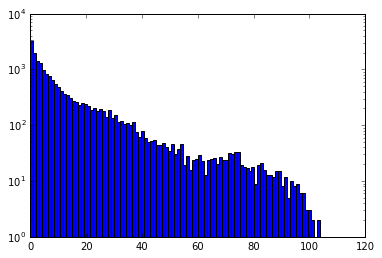

In [31]:
all_v4 = v4.values.ravel()
all_v4 = all_v4[~np.isnan(all_v4)]
_ = plt.hist(all_v4,log=True, bins=100)

Looks good, seem to be the raw responses, without the mean subtracted.
Now lets tack our pathological cells on to the V4 data set, and subtract the mean of the shapes at each position.

In [32]:
v4 = xr.concat([min_ti_unit, max_ti_unit, v4], dim='unit')
v4 = v4 - v4.mean('shapes')